Universidad del Valle de Guatemala <br>
28/01/2022 <br>
Minería de Datos # 20 

# Hoja de Trabajo 2
## Clustering

**Integrantes:**<br>
Walter Saldaña 19897 <br>
José Gutierrez 19111 <br>
Javier Cotto 19324 <br>

Importar modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Cargar la base de datos a pandas

In [2]:
datos = pd.read_csv('movies.csv', encoding='unicode_escape')
datos.head()

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,popularity,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
0,5,4000000,Crime|Comedy,https://www.miramax.com/movie/four-rooms/,Miramax|A Band Apart,US|US,United States of America,4257354.0,98,False,...,20.880,1995-12-09,5.7,2077,2,2,1,25,15,9
1,6,21000000,Action|Thriller|Crime,NaN,Universal Pictures|Largo Entertainment|JVC,US|US|JP,Japan|United States of America,12136938.0,110,False,...,9.596,1993-10-15,6.5,223,3,3,2,15,3,9
2,11,11000000,Adventure|Action|Science Fiction,http://www.starwars.com/films/star-wars-episod...,Lucasfilm|20th Century Fox,US|US,United States of America,775398007.0,121,NaN,...,100.003,1977-05-25,8.2,16598,3,2,1,105,5,62
3,12,94000000,Animation|Family,http://movies.disney.com/finding-nemo,Pixar,US,United States of America,940335536.0,100,NaN,...,134.435,2003-05-30,7.8,15928,2,1,1,24,5,18
4,13,55000000,Comedy|Drama|Romance,NaN,Paramount|The Steve Tisch Company,US|,United States of America,677387716.0,142,False,...,58.751,1994-07-06,8.5,22045,3,2,1,76,18,48


## 1) Preprocesamiento de datos
Remover variables cualitativas que no aportan, ya que no son categóricas, y sus frecuencias no pueden ser clasificadas.

In [3]:
datos = datos.drop(["id", "originalTitle", "originalLanguage", "title", "homePage", "video", "director", "genres", "productionCompany", "productionCompanyCountry", "productionCountry", "actors", "actorsPopularity", "actorsCharacter", "releaseDate", "castMenAmount", "castWomenAmount", "productionCoAmount", "productionCountriesAmount", "actorsAmount", "genresAmount"], axis=1)
datos.head()

,budget,revenue,runtime,popularity,voteAvg,voteCount
0,4000000,4257354.0,98,20.880,5.7,2077
1,21000000,12136938.0,110,9.596,6.5,223
2,11000000,775398007.0,121,100.003,8.2,16598
3,94000000,940335536.0,100,134.435,7.8,15928
4,55000000,677387716.0,142,58.751,8.5,22045


### Resumen estadístico de las variables

In [4]:
datos.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.855163e+07,5.673793e+07,100.268100,51.393907,6.483490,1342.381800
std,3.662669e+07,1.495854e+08,27.777829,216.729552,0.984274,2564.196637
min,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000
25%,0.000000e+00,0.000000e+00,90.000000,14.577750,5.900000,120.000000
50%,5.000000e+05,1.631245e+05,100.000000,21.905500,6.500000,415.000000
75%,2.000000e+07,4.479661e+07,113.000000,40.654000,7.200000,1316.000000
max,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000


### Muestra representativa de la población

In [5]:
datos["combined"] = list(
    zip(
        datos["budget"],
        datos["revenue"],
        datos["runtime"],
        datos["popularity"],
        datos["voteAvg"],
        datos["voteCount"]
    )
)

combined_weight = datos['combined'].value_counts(normalize=True)

datos['combined_weight'] = datos['combined'].apply(lambda x: combined_weight[x])

datos = datos.sample(150, weights=datos['combined_weight'])

datos.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount,combined_weight
count,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,1.500000e+02
mean,2.404661e+07,8.698388e+07,101.153333,61.842087,6.464667,1468.986667,1.000000e-04
std,5.251672e+07,2.675025e+08,24.329322,105.607880,0.890226,2641.123820,2.719586e-20
min,0.000000e+00,0.000000e+00,12.000000,8.540000,4.000000,6.000000,1.000000e-04
25%,0.000000e+00,0.000000e+00,91.250000,15.787000,5.900000,124.000000,1.000000e-04
50%,0.000000e+00,1.531900e+04,97.000000,25.467000,6.400000,449.500000,1.000000e-04
75%,1.775000e+07,5.685725e+07,110.750000,55.493250,7.100000,1660.500000,1.000000e-04
max,3.560000e+08,2.797801e+09,242.000000,705.492000,8.600000,20186.000000,1.000000e-04


### Análisis de la columna BUDGET

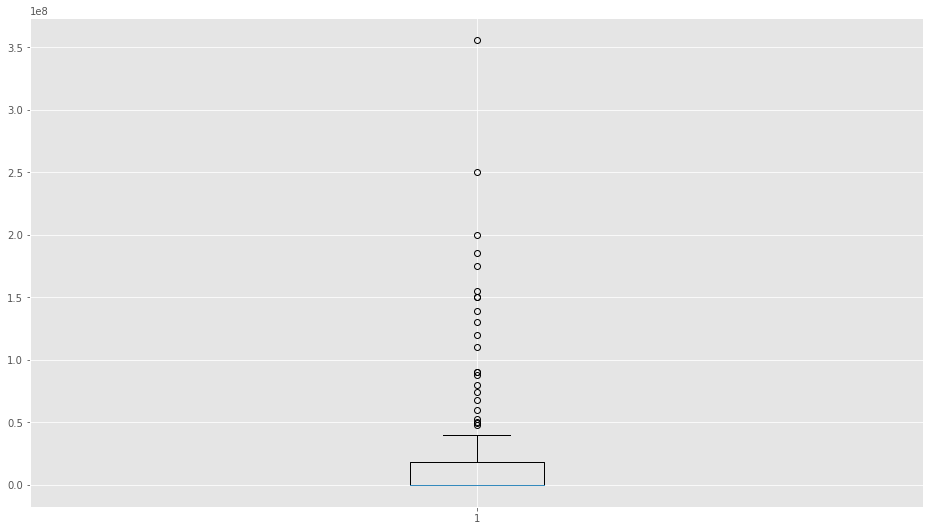

In [6]:
plt.boxplot(datos.budget)
plt.show()

Eliminar datos atípicos

In [7]:
indexes = datos[datos['budget'] < 5e5].index
datos.drop(indexes, inplace=True)

Q1 = datos.budget.quantile(0.25)
Q3 = datos.budget.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['budget'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['budget'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

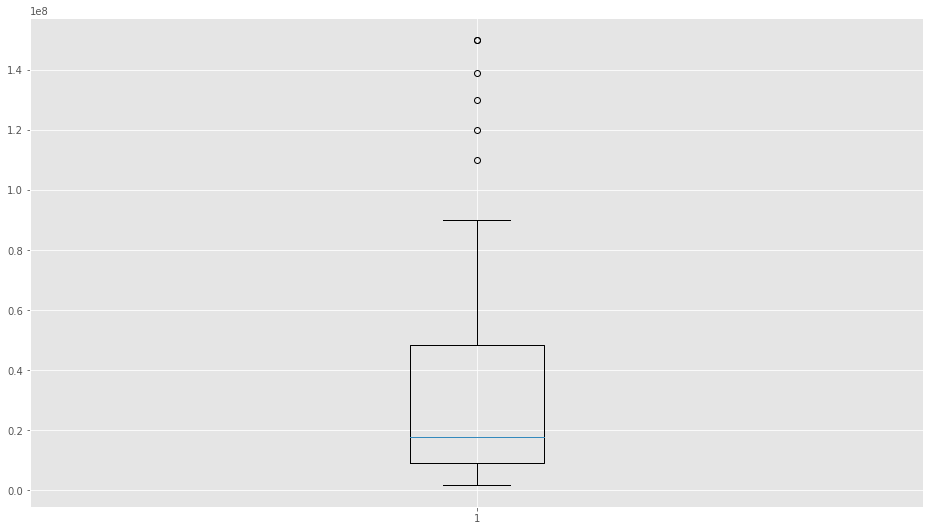

In [8]:
plt.boxplot(datos.budget)
plt.show()

### Análisis de la columna REVENUE

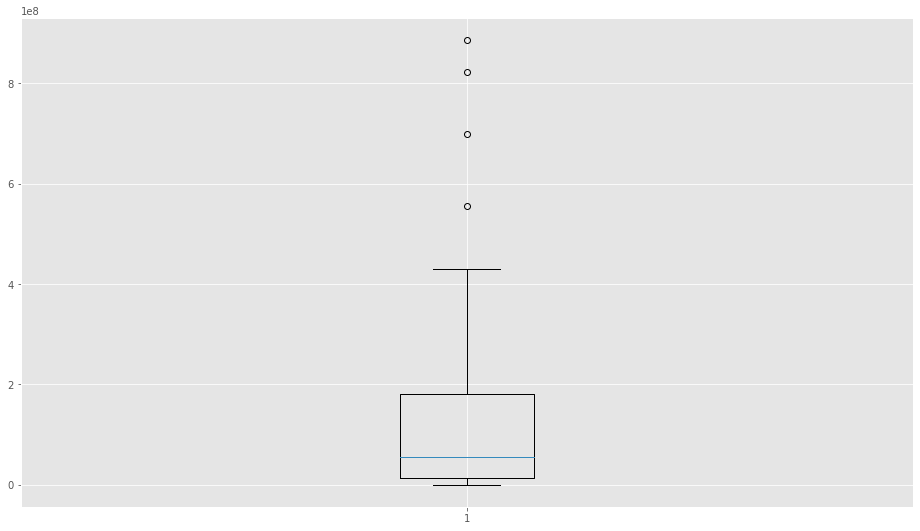

In [9]:
plt.boxplot(datos.revenue)
plt.show()

Eliminar datos atípicos

In [10]:
Q1 = datos.budget.quantile(0.25)
Q3 = datos.budget.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['budget'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['budget'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

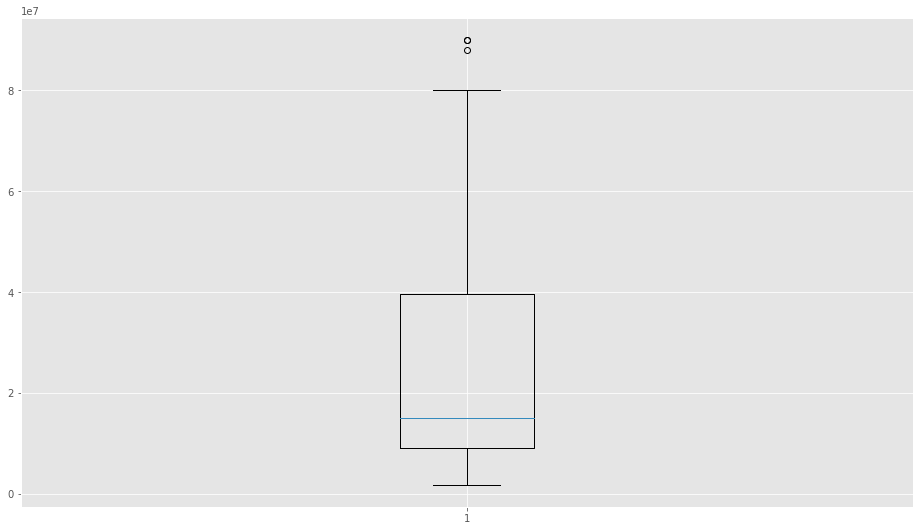

In [11]:
plt.boxplot(datos.budget)
plt.show()

### Análisis de la columna RUNTIME

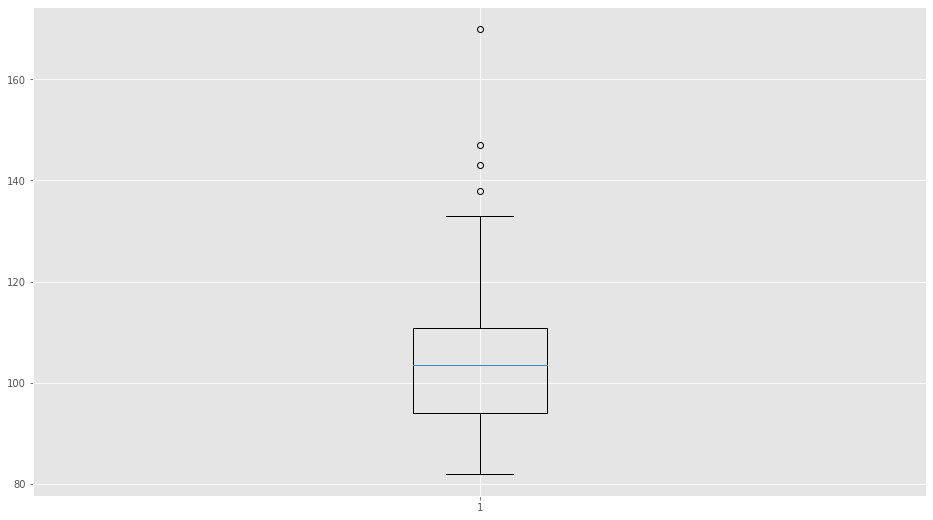

In [12]:
plt.boxplot(datos.runtime)
plt.show()

Eliminar datos atípicos

In [13]:
Q1 = datos.runtime.quantile(0.25)
Q3 = datos.runtime.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['runtime'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['runtime'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

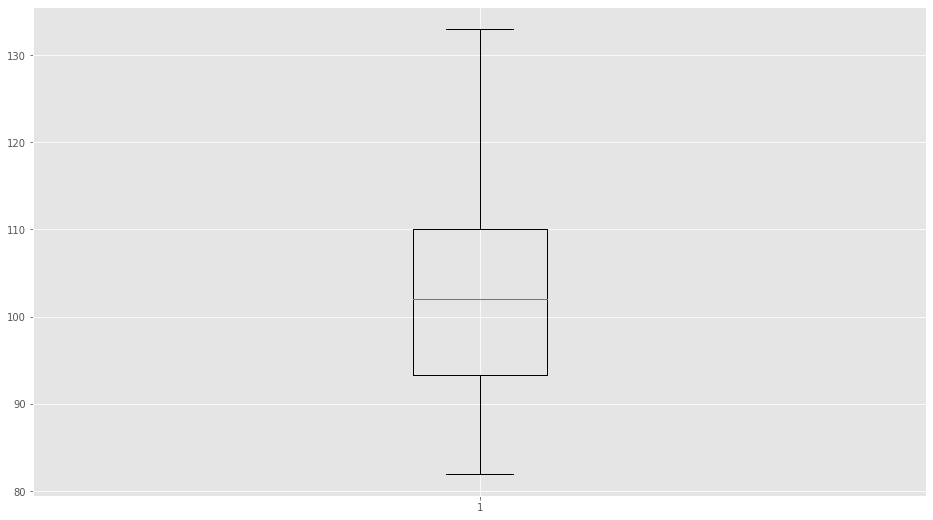

In [14]:
plt.boxplot(datos.runtime)
plt.show()

### Análisis de la columna POPULARITY

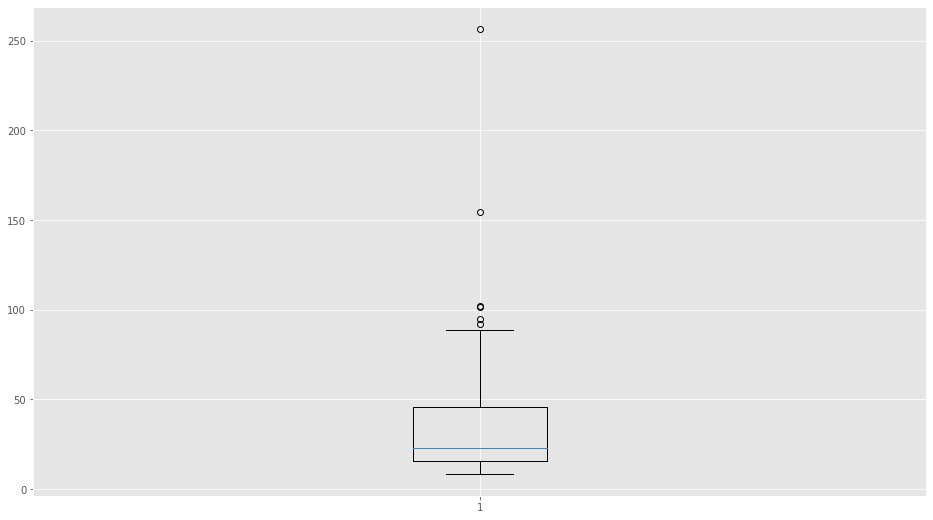

In [15]:
plt.boxplot(datos.popularity)
plt.show()

Eliminar datos atípicos

In [16]:
Q1 = datos.popularity.quantile(0.25)
Q3 = datos.popularity.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['popularity'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['popularity'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

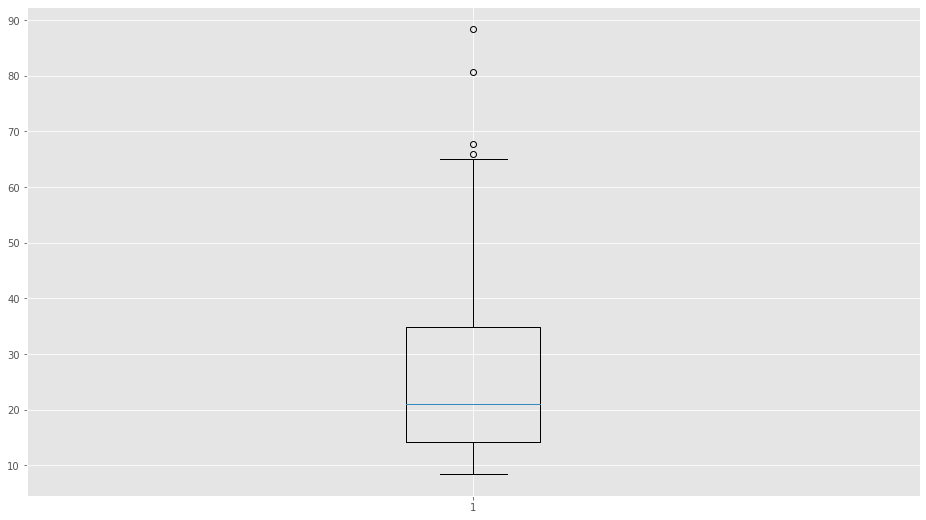

In [17]:
plt.boxplot(datos.popularity)
plt.show()

### Análisis de la columna VOTEAVG

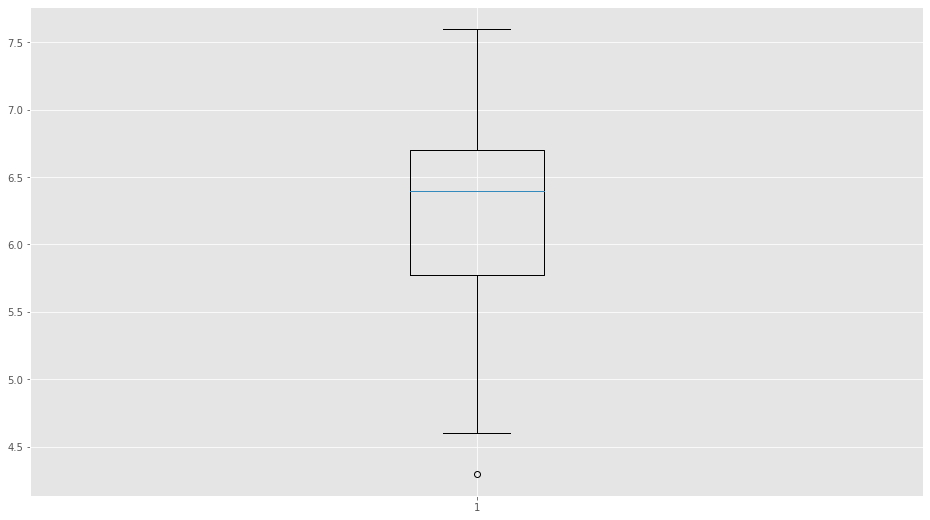

In [18]:
plt.boxplot(datos.voteAvg)
plt.show()

Eliminar datos atípicos

In [19]:
Q1 = datos.voteAvg.quantile(0.25)
Q3 = datos.voteAvg.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['voteAvg'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['voteAvg'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

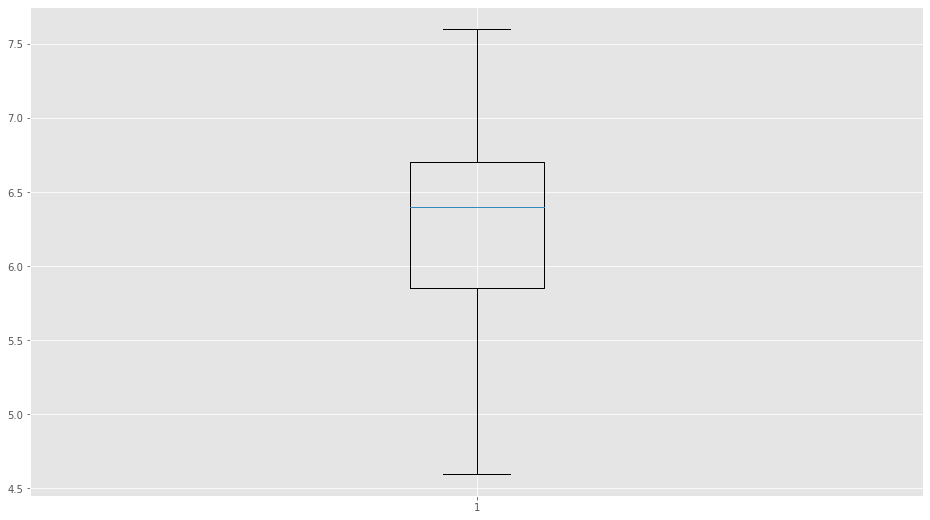

In [20]:
plt.boxplot(datos.voteAvg)
plt.show()

### Análisis de la columna VOTECOUNT

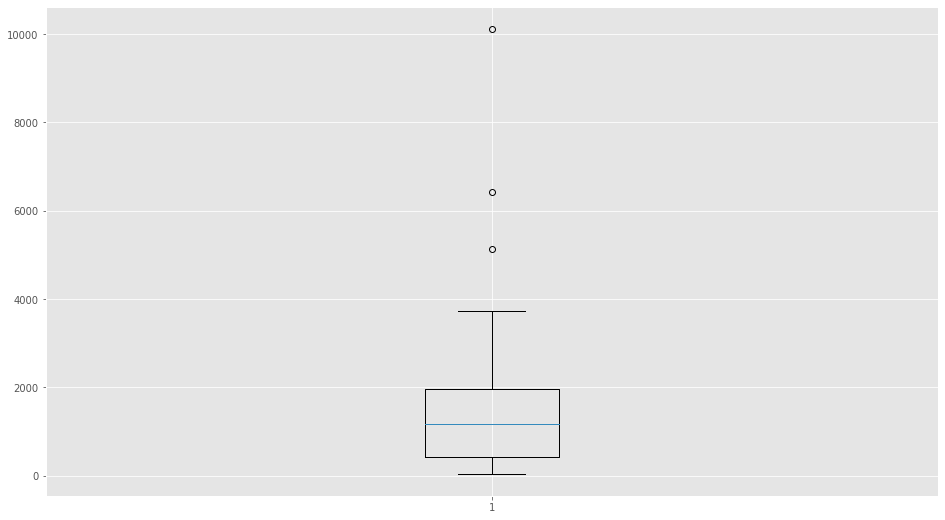

In [21]:
plt.boxplot(datos.voteCount)
plt.show()

Eliminar datos atípicos

In [22]:
Q1 = datos.voteCount.quantile(0.25)
Q3 = datos.voteCount.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['voteCount'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['voteCount'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

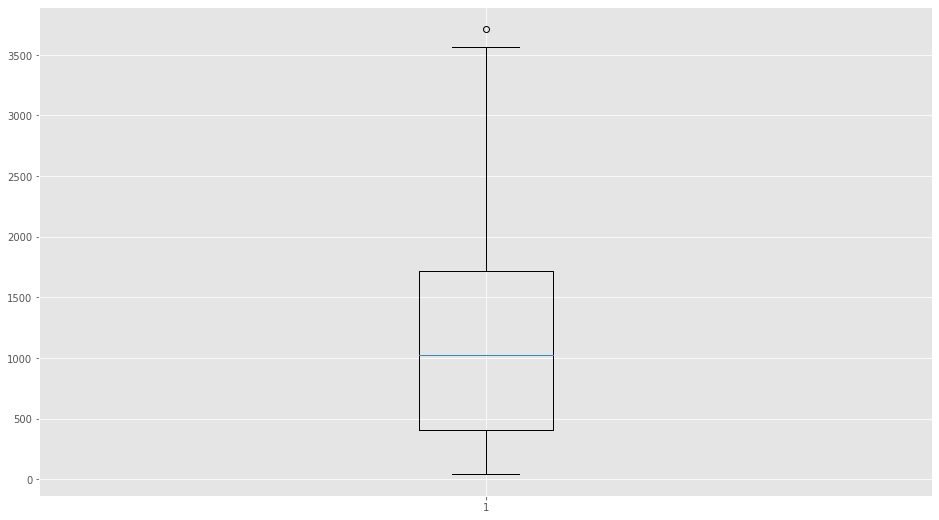

In [23]:
plt.boxplot(datos.voteCount)
plt.show()

### Correlación de las variables

<AxesSubplot:>

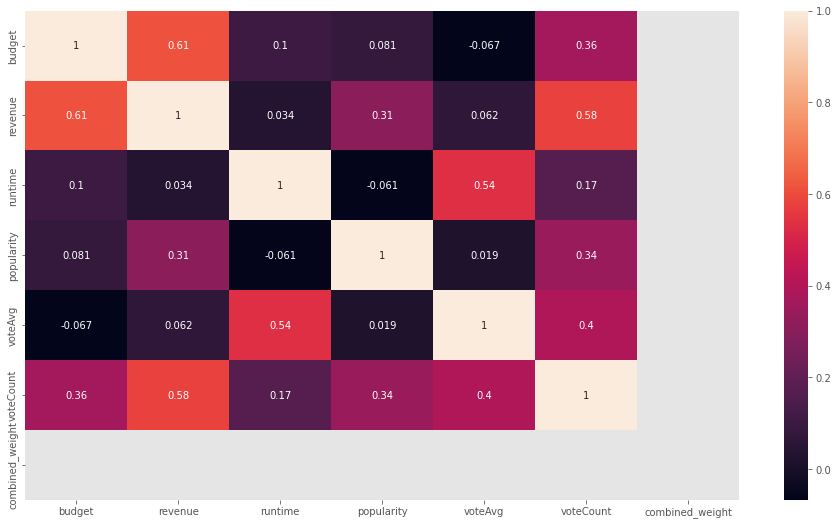

In [24]:
correlacion = datos.corr()
fig, axis = plt.subplots()
sb.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

#### Correlaciones más relevantes

- **Budget:** revenue
- **Revenue:** budget, voteCount
- **Runtime:** voteAvg
- **Popularity:** voteCount
- **VoteAvg:** runtime, voteCount
- **VoteCount:** revenue, popularity, voteAvg

## 2) Tendencia al agrupamiento

### Evaluación de posibles agrupamientos con Estadístico de Hopkings y VAT

#### VoteAvg, VoteCount

In [ ]:
votes = datos
votes = votes.drop(["budget", "revenue", "runtime", "popularity"], axis=1)

pyclustertend.hopkins(votes,len(votes))

In [ ]:
pyclustertend.vat(votes)

#### VoteAvg, VoteCount, Runtime

In [ ]:
votes_runtime = datos
votes_runtime = votes_runtime.drop(["budget", "revenue", "popularity"], axis=1)

pyclustertend.hopkins(votes_runtime,len(votes_runtime))

In [ ]:
pyclustertend.vat(votes_runtime)

#### Popularity, voteCount

In [ ]:
popularity_votecount = datos
popularity_votecount = popularity_votecount.drop(["budget", "revenue", "runtime", "voteAvg"], axis=1)

pyclustertend.hopkins(popularity_votecount,len(popularity_votecount))

In [ ]:
pyclustertend.vat(popularity_votecount)

#### VoteCount, VoteAvg, Popularity

In [ ]:
votes_popularity = datos
votes_popularity = votes_popularity.drop(["budget", "revenue", "runtime"], axis=1)

pyclustertend.hopkins(votes_popularity,len(votes_popularity))

In [ ]:
pyclustertend.vat(votes_popularity)